# Volume 4: Solitons
    Benj McMullin
    Math 439
    3/7/2024

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.fft import fft, ifft

c:\Users\benja\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Problem 1

Write a function that accepts the time value $t$ (which won't be used here, but will be useful later) the vector $\mathbf{y}=(y_0,y_1,\ldots,y_n,y_{-n-1},\ldots,y_{-1})$ and the vector of $k$ values and returns $\mathbf{y}'$.

In [2]:
# Function for the ODE of the coefficients
def kdv_pseudospectral_ode(t, y, k):
    """
    Given the spectral coefficients y, calculates y'.
    Parameters:
        t (float): The current time
        y ((2n+2,) array): The current spectral coefficients
        k ((2n+2,) array): The vector of wavenumbers
    """
    return -.5 * 1j * k * fft(ifft(y)**2) + 1j * k**3 * y

# Problem 2

Write a function that accepts an initial condition `u0`, a final time `T`, the timestep `dt`, an integer `n` for the number of coefficients to use, and another integer `skip`.
Numerically solve for the coefficients $\mathbf{y}(t)$ of a solution to the KdV equation.

Next, convert the Fourier coefficients back into function values at the gridpoints using the inverse Fourier transform.
However, only do this for every `skip`-th timestep; we will be using far more timesteps than we want to plot.
Return the gridpoints, the timesteps, and the solution $u(x,t)$.

In [4]:
# Provided function for integration
def RK4(f, y0, T, dt, k):
    """
    Solves the ODE y'=f(t, y) using the Runge-Kutta 4 method with initial 
    condition y0 on the time interval [0,T] using a time step of dt.
    The value of k is passed directly into the function f.
    
    Returns:
        t ((n_t,) ndarray) - the time values
        Y ((n_t, 2n+2) ndarray) - the solution values. The solution at the 
                i-th time step can be indexed as Y[i].
    """
    # Set up matrices for the solution
    ts = np.arange(0, T+dt, dt)
    Y = np.empty((len(ts),len(k)), dtype=complex)
    y = y0
    Y[0] = y
    for i in range(1, len(ts)):
        # Use RK4
        t = ts[i]
        K1 = f(t, y, k)
        K2 = f(t + dt/2, y + 0.5*dt*K1, k)
        K3 = f(t + dt/2, y + 0.5*dt*K2, k)
        K4 = f(t + dt, y + dt*K3, k)
        y = y + (dt / 6.) * (K1 + 2*K2 + 2*K3 + K4)
        Y[i] = y
    return ts, Y

In [5]:
def solve_kdv(u0, T, dt, n, skip):
    """
    Solve the KdV equation for x in [-pi, pi] and t in [0,T] with the given initial condition.
    
    Parameters:
        u0 - the initial conditions
        T (float) - the final time to solve until
        dt - the time step
        n - the number of points in space to use
        skip - only return every skip-th time step
    
    Returns:
        t ((n_t,) ndarray)
        x ((2n+2,) ndarray)
        u ((n_t, 2n+2) ndarray)
    """
    # Compute the discrete Fourier transform of the initial condition u0 using FFT
    y0 = fft(u0)

    # Create the wave number array k for the given number of grid points n
    k = np.concatenate([np.arange(0, n+1), np.arange(-n-1, 0)])

    # Integrate the KdV equation using the Runge-Kutta 4th order (RK4) method
    # The function kdv_pseudospectral_ode contains the right-hand side of the KdV equation
    # T is the total integration time, dt is the time step
    # ts contains the time steps, y contains the solution at each time step
    ts, y = RK4(kdv_pseudospectral_ode, y0, T, dt, k)

    # Compute the inverse Fourier transform of y to obtain the solution u in physical space
    # Skip some points in y to reduce the computational cost, and extract the real part
    us = np.real(ifft(y[::skip, :], axis=1))

    # Return the time steps, y (solution in Fourier space), and us (solution in physical space)
    return ts[::skip], y, us    

# Problem 3


Numerically solve the KdV equation on $[−π, π]$ with $n=127$ with initial
conditions
$$
u(x, t = 0) = 3s\,\mathrm{sech}^2
\left(\frac{\sqrt{s}}{2}(x + a)\right),
$$
where $s = 25^2$, $a = 2$. Solve on the time domain $[0, 0.0075]$. 
Plot the solution.
How small of a timestep did you need to use for the numerical integration to be stable?

In [6]:
# Initialize parameters
s = 25**2  
a = 2  
n = 127  
domain = np.linspace(-np.pi, np.pi, 2*n+2)  
T = 0.0075  
dt = 0.000001  

# Initial condition for the KdV equation
u0 = [3*s / np.cosh(np.sqrt(s)/2 * (x+a))**2 for x in domain]

# Solve the KdV equation
ts, y, u = solve_kdv(u0, T, dt, n, 20)

# Print the time step size
print(dt)

1e-06


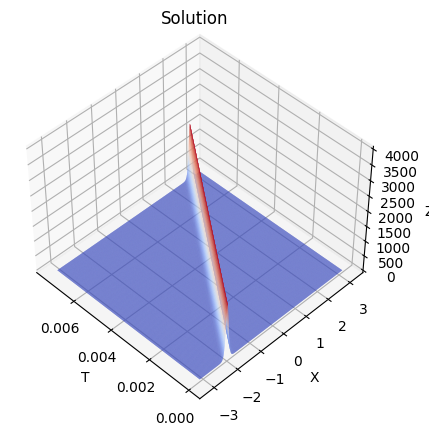

In [7]:
# Plot the solution
fig = plt.figure()  # Create a new figure
ax = fig.add_subplot(1,1,1,projection='3d')  # Add a 3D subplot to the figure

# Create a meshgrid of time steps (T) and spatial domain (X)
T, X = np.meshgrid(ts, domain, indexing='ij')

# Set the view angle for the plot
ax.view_init(elev=45, azim=-45)

# Set limits for the z-axis
ax.set_zlim(0, 4000)

# Invert the x-axis
ax.invert_xaxis()

# Set labels for the axes
ax.set_xlabel("T")
ax.set_ylabel("X")
ax.set_zlabel("Z")

# Set title for the plot
ax.set_title("Solution")

# Plot the surface
ax.plot_surface(T, X, u, cmap='coolwarm', rstride=1, cstride=1)

# Problem 4

Numerically solve the KdV equation on $[−π, π]$. This time we define the initial
condition to be the superposition of two solitons,
$$
u(x,t=0) 
= 3s_1\mathrm{sech}^2\left(\frac{\sqrt{s_1}}{2}(x+a_1)\right) 
+ 3s_2\mathrm{sech}^2\left(\frac{\sqrt{s_2}}{2}(x+a_2)\right),
$$

where $s_1 = 25^2$, $a_1 = 2$, and $s_2 = 16^2$, $a_2 = 1$.
Solve on the time domain $[0, 0.0075]$. 
Plot the solution.

In [8]:
# Initialize parameters
s1, s2 = 25**2, 16**2  # Parameters for the initial conditions
a1, a2 = 2, 1  # Shift parameters for the initial conditions
n = 127  # Number of grid points
domain = np.linspace(-np.pi, np.pi, 2*n+2)  # Domain of the problem
T = 0.0075  # Total integration time
dt = 0.000001  # Time step size

# Initial condition for the KdV equation
# u0 is a list comprehension to compute the initial condition for each point in the domain
# The initial condition is a superposition of two solitons
u0 = [3*s1 / np.cosh(np.sqrt(s1)/2 * (x+a1))**2 + 3*s2 / np.cosh(np.sqrt(s2)/2 * (x+a2))**2 for x in domain]

# Solve the KdV equation
ts, y, u = solve_kdv(u0, T, dt, n, 20)

# Print the time step size
print(dt)

1e-06


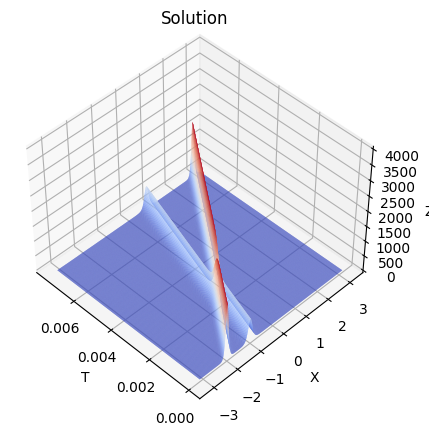

In [9]:
# Plot the solution
fig = plt.figure()  # Create a new figure
ax = fig.add_subplot(1,1,1,projection='3d')  # Add a 3D subplot to the figure

# Create a meshgrid of time steps (T) and spatial domain (X)
T, X = np.meshgrid(ts, domain, indexing='ij')

# Set the view angle for the plot
ax.view_init(elev=45, azim=-45)

# Set limits for the z-axis
ax.set_zlim(0, 4000)

# Invert the x-axis
ax.invert_xaxis()

# Set labels for the axes
ax.set_xlabel("T")
ax.set_ylabel("X")
ax.set_zlabel("Z")

# Set title for the plot
ax.set_title("Solution")

# Plot the surface
ax.plot_surface(T, X, u, cmap='coolwarm', rstride=1, cstride=1)

# Problem 5

Consider again the ODE for the spectral coefficients.
The linear term in this equation is $i\mathbf{k}^3\mathbf{y}$.
This term contributes much of the exponential growth in the ODE, and contributes to how short the time step must be to ensure numerical stability.
Make the substitution $z_k(t) = e^{-ik^3t}y_k(t)$ and find a similar ODE for $\mathbf{z}$.
This essentially allows the exponential growth to be scaled out (it's solved for analytically, replacing it with rotation in the complex plane).

Use the resulting equation to solve the previous problem.
How much larger of a timestep can you use while this method remains stable?

In [10]:
# Function for the ODE of the coefficients
def kdv_pseudospectral_ode_for_5(t, y, k):
    """
    Given the spectral coefficients y, calculates y'.
    
    Args:
        t (float): Current time.
        y (array-like): Spectral coefficients.
        k (array-like): Wave numbers.
        
    Returns:
        array-like: First derivative of spectral coefficients.
    """
    return -0.5j * k * np.exp(-1j * k**3 * t) * fft(ifft(y / np.exp(-1j * k**3 * t))**2)

def solve_kdv_for_5(u0, T, dt, n, skip):
    """
    Solve the KdV equation for x in [-pi, pi] and t in [0,T] with the given initial condition.
    
    Args:
        u0 (array-like): Initial condition.
        T (float): Total integration time.
        dt (float): Time step size.
        n (int): Number of grid points.
        skip (int): Skip factor for output data.
    
    Returns:
        ts (array-like): Time steps.
        y (array-like): Spectral coefficients over time.
        us (array-like): Solution in physical space over time.
    """
    # Compute initial spectral coefficients
    y0 = fft(u0)
    
    # Compute wave numbers
    k = np.concatenate([np.arange(0, n + 1), np.arange(-n - 1, 0)])
    
    # Solve the ODE for spectral coefficients
    ts, z = RK4(kdv_pseudospectral_ode_for_5, y0, T, dt, k)
    
    # Convert spectral coefficients to physical space
    y = z / np.exp(-1j * k.reshape(1, -1)**3 * ts.reshape(-1, 1))
    us = np.real(ifft(y[::skip, :], axis=1))
    
    return ts[::skip], y, us

In [11]:
# Initialize parameters
s1, s2 = 25**2, 16**2  # Parameters for the initial conditions
a1, a2 = 2, 1  # Shift parameters for the initial conditions
n = 127  # Number of grid points
domain = np.linspace(-np.pi, np.pi, 2*n+2)  # Domain of the problem
T = 0.0075  # Total integration time
dt = 3e-6  # Time step size

# Initial condition for the KdV equation
# u0 is a list comprehension to compute the initial condition for each point in the domain
# The initial condition is a superposition of two solitons
u0 = [3*s1 / np.cosh(np.sqrt(s1)/2 * (x+a1))**2 + 3*s2 / np.cosh(np.sqrt(s2)/2 * (x+a2))**2 for x in domain]

# Solve the KdV equation
# ts contains the time steps, y contains the solution in Fourier space, u contains the solution in physical space
ts, y, u = solve_kdv_for_5(u0, T, dt, n, 20)

# Print the time step size
print(dt)

3e-06


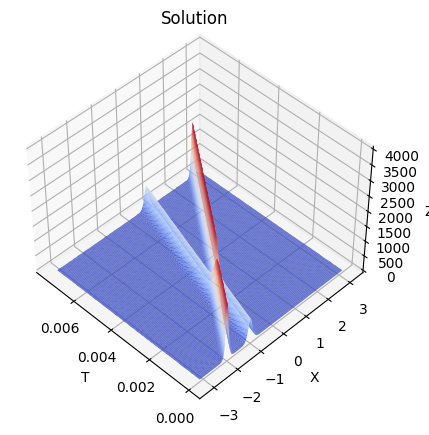

In [12]:
# Plot the solution
fig = plt.figure()  # Create a new figure
ax = fig.add_subplot(1,1,1,projection='3d')  # Add a 3D subplot to the figure

# Create a meshgrid of time steps (T) and spatial domain (X)
T, X = np.meshgrid(ts, domain, indexing='ij')

# Set the view angle for the plot
ax.view_init(elev=45, azim=-45)

# Set limits for the z-axis
ax.set_zlim(0, 4000)

# Invert the x-axis
ax.invert_xaxis()

# Set labels for the axes
ax.set_xlabel("T")
ax.set_ylabel("X")
ax.set_zlabel("Z")

# Set title for the plot
ax.set_title("Solution")

# Plot the surface
ax.plot_surface(T, X, u, cmap='coolwarm', rstride=1, cstride=1)